# Surface Mass Balance: XGB 

Import relevant Libaries 

In [1]:
%pip install pyarrow
%pip install plotly
%pip install feature_engine
%pip update pandas

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: unknown command "update"
Note: you may need to restart the kernel to use updated packages.


In [201]:
# Base libraries
import pandas as pd
import numpy as np
import os
import math as math
import datetime
from scipy import stats

# Visualizations
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns

# Set WD
import os
from pyrsistent import v
os.getcwd()
#os.chdir('/Users/asgerlyngeholst-hansen/Desktop/GEUS-Master-Thesis/')
#os.chdir('C:\\Users\\nifu18ab\\Desktop\\GEUS-Master-Thesis')
#os.chdir('/Users/nilsfulde/Desktop/GEUS-Master-Thesis')
os.chdir('/Users/nilsfulde/Desktop/Master_Thesis')

#### Load KM_L 

In [210]:
df = pd.read_csv('data/promice/preprocessed/daily/KAN_L.csv')

##### Pre-processing

In [211]:
#Remove the first NAN value for DELTA
df = df[df['Surface height from combined measurements DELTA'].notna()]

In [212]:
# This bit retrieve the indexes for all melting season categories and remove column from df
for category in ['pre', 'beginning', 'middle', 'end']:
    exec(f"indices_{category} = df[df['Melting Season'] == '{category}'].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

# This bit retrieve the indexes for Ablation periods
for category in [True]:
    exec(f"indices_ablation = df[df['Ablation'] == {category}].index")

In [233]:
indices_ablation

Int64Index([   1,    2,    3,    4,   11,   12,   13,   14,   15,   16,
            ...
            5133, 5134, 5135, 5136, 5137, 5138, 5139, 5140, 5141, 5142],
           dtype='int64', length=1556)

In [235]:
list(df.index.values)

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [213]:
filtered = df[df['Ablation'] == True]
pd.DataFrame(filtered.isna().sum(), columns = ["Sum of missing values"])

,Sum of missing values
Unnamed: 0,0
stid,0
Datetime,0
Air pressure (upper boom),0
Air temperature (upper boom),0
Relative humidity (upper boom) - corrected,0
Specific humidity (upper boom),0
Wind speed (upper boom),0
Wind from direction (upper boom),0
Downwelling shortwave radiation - corrected,0


In [214]:
# This bit to include only relevant features
exclude_list = [                                                    'index', # excluded because of unimportant information
                                                                     'stid', # excluded because of unimportant information
                                                               'Unnamed: 0', # Old Index
                                                                 'Ablation',
                                                           'Melting Season',
                                              'year', 'month','day', 'hour' # Drop because of sin & cos values
               ]

df = df[[column for column in df.columns if column not in exclude_list]]


In [215]:
# This bit to change the datetime variables into a form that a ML models can understand
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html
    
    
# This bit to split Datetime column into year, month, day, hour columns
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Datetime'] = df['Datetime'].dt.strftime('%Y-%m-%d')

df['Datetime'] = pd.to_datetime(df['Datetime'])

#Create new columns
df['year'] = df['Datetime'].dt.year # Maybe we need to exclude year???
df['month'] = df['Datetime'].dt.month
df['day'] = df['Datetime'].dt.day
#df['hour'] = df['Datetime'].dt.hour

#Drop the datetime column
df.drop(columns=['Datetime'], inplace=True)

In [216]:
# This bit to change the datetime variables into a form that a ML models can understand (continued)
  # https://ianlondon.github.io/blog/encoding-cyclical-features-24hour-time/
  # https://feature-engine.trainindata.com/en/1.3.x/user_guide/creation/CyclicalFeatures.html 

# Use CyclicalFeatures Package to convert year, month, day & hour
from feature_engine.creation import CyclicalFeatures

cyclical = CyclicalFeatures(variables=None, drop_original=True)


#cyclical = cyclical.fit_transform(df[['month', 'year']]) # with year
cyclical = cyclical.fit_transform(df[['month']]) # without year
df = pd.merge(df, cyclical, left_index=True, right_index=True)

df = df[[column for column in df.columns if column not in exclude_list]]

In [217]:
# This bit to convert all numerical values into the same scale 
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler


scalers = [StandardScaler(), MinMaxScaler(), RobustScaler()]
#num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos','year_sin','year_cos'], axis=1).columns #select numerical columns except y and cyclical feature
num_cols = df.select_dtypes(include=['int64','float64']).drop(['Surface height from combined measurements', 'Surface height from combined measurements DELTA','month_sin','month_cos'], axis=1).columns #select numerical columns except y and cyclical feature

scaler = MinMaxScaler()

#fit and transform numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [218]:
# This bit to split into Train & Test
from sklearn.model_selection import train_test_split

# Delta
df_delta = df[[column for column in df.columns if column not in ["Surface height from combined measurements"]]]
X_delta = df_delta.loc[:, df_delta.columns != "Surface height from combined measurements DELTA"] # All features except y
y_delta = df_delta["Surface height from combined measurements DELTA"]

# using the train test split function
X_delta_train, X_delta_test,y_delta_train, y_delta_test = train_test_split(X_delta,y_delta,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

# Absolute
df_absolute = df[[column for column in df.columns if column not in ["Surface height from combined measurements DELTA"]]]
X_absolute = df_absolute.loc[:, df_absolute.columns != "Surface height from combined measurements"] # All features except y
y_absolute = df_absolute["Surface height from combined measurements"]

# using the train test split function
X_absolute_train, X_absolute_test,y_absolute_train, y_absolute_test = train_test_split(X_absolute,y_absolute ,
                                   random_state=2023, 
                                   test_size=0.3, 
                                   shuffle=True)

## XGB Regression

In [220]:
# Import required libraries
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

In [221]:
# This bit to find best XBG Regressor model for when Ablation == True and for both target variables

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Define the XGBRegressor model
    #model = xgb.XGBRegressor()
    exec(f"model_{i} = xgb.XGBRegressor()")
    
    # Define the hyperparameter grid for tuning
    param_grid = {
        'max_depth': [3], #[3, 5, 7],
        'min_child_weight': [1], #[1, 3, 5],
        'learning_rate': [0.1], #[0.1, 0.01, 0.001],
        'n_estimators': [100], #[100, 500, 1000],
        'subsample': [0.5], #[0.5, 0.7, 1.0],
        'colsample_bytree': [0.7], #[0.5, 0.7, 1.0],
        'reg_alpha': [0.1], #[0, 0.1, 0.5],
        'reg_lambda': [0.1], #[0, 0.1, 0.5]
    }

    # Define the grid search object
    grid_search = GridSearchCV(eval(f"model_{i}"), param_grid = param_grid, cv=5, n_jobs=-1, verbose=0)

    # Fit the grid search object to the training data
    grid_search.fit(X_train_category, y_train_category)
    
    # Print the best hyperparameters and the corresponding R^2 score on the test set
    print(f"Best hyperparameters_{i}: ", grid_search.best_params_)
    
    # Save the best model parameters as 'model' variable
    exec(f"model_{i} = grid_search.best_estimator_")
    
    # Evaluate the best model on the test set
    y_pred_category = eval(f"model_{i}").predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)

Best hyperparameters_delta:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (delta):  0.3767311106719937
MSE on test set (delta):  0.023176978509147576
Best hyperparameters_absolute:  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.5}
R^2 score on test set (absolute):  0.3172174694865245
MSE on test set (absolute):  168.75320719863151


In [222]:
# This bit to see output of the best absolute model

indices = eval(f"indices_ablation")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_absolute_test.index)
y_Test_valid_indices = indices.intersection(y_absolute_test.index)

# filter out by indeces
X_test_category = X_absolute_test.loc[X_Test_valid_indices]  
y_test_category = y_absolute_test.loc[y_Test_valid_indices]

y_pred_category = model_absolute.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.3172174694865245
MSE on test set:  168.75320719863151


In [223]:
# This bit to see output of the best delta model

indices = eval(f"indices_ablation")

# Find common indexes
X_Test_valid_indices = indices.intersection(X_delta_test.index)
y_Test_valid_indices = indices.intersection(y_delta_test.index)

# filter out by indeces
X_test_category = X_delta_test.loc[X_Test_valid_indices]  
y_test_category = y_delta_test.loc[y_Test_valid_indices]

y_pred_category = model_delta.predict(X_test_category)
r2 = r2_score(y_test_category, y_pred_category)
mse = mean_squared_error(y_test_category, y_pred_category)
print(f"R^2 score on test set: ", r2)
print(f"MSE on test set: ", mse)

R^2 score on test set:  0.3767311106719937
MSE on test set:  0.023176978509147576


## Filter by Melting Season

R^2 score on test set (pre):  -0.20115631974984183
MSE on test set (pre):  0.005793102530668917
                                        Feature  Importance
0                                        Albedo    0.178307
1               Sensible heat flux (upper boom)    0.131090
2                       Wind speed (upper boom)    0.096646
3                  Air temperature (upper boom)    0.087905
4                Specific humidity (upper boom)    0.059705
5   Downwelling shortwave radiation - corrected    0.058064
6              Wind from direction (upper boom)    0.055126
7                           Surface temperature    0.051175
8                     Air pressure (upper boom)    0.050054
9                                     month_cos    0.043784
10                 Upwelling longwave radiation    0.041385
11   Relative humidity (upper boom) - corrected    0.040413
12                Latent heat flux (upper boom)    0.030508
13    Upwelling shortwave radiation - corrected    0.030182
14  

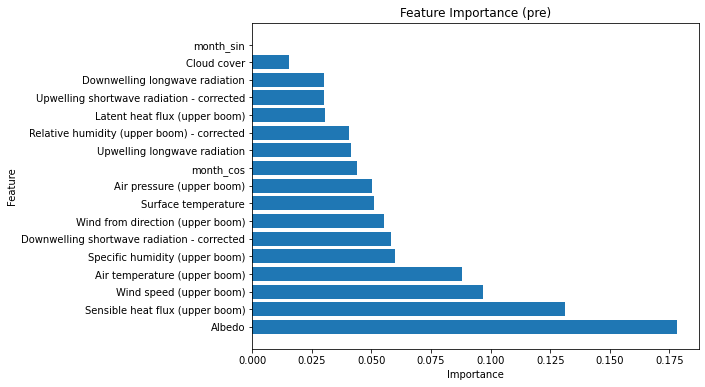

R^2 score on test set (beginning):  0.2587574890629606
MSE on test set (beginning):  0.15952118113397298
                                        Feature  Importance
0                     Air pressure (upper boom)    0.167891
1     Upwelling shortwave radiation - corrected    0.163429
2    Relative humidity (upper boom) - corrected    0.087905
3              Wind from direction (upper boom)    0.086454
4                                        Albedo    0.073681
5                Specific humidity (upper boom)    0.070332
6                  Air temperature (upper boom)    0.067953
7                           Surface temperature    0.063241
8                  Upwelling longwave radiation    0.050388
9               Sensible heat flux (upper boom)    0.036760
10                      Wind speed (upper boom)    0.036354
11               Downwelling longwave radiation    0.028603
12                Latent heat flux (upper boom)    0.023361
13                                  Cloud cover    0.02

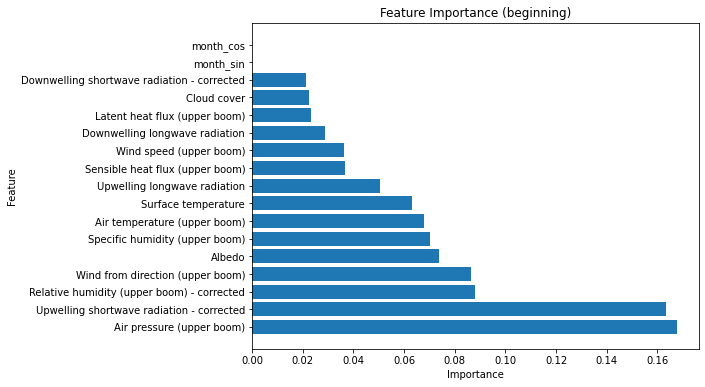

R^2 score on test set (middle):  0.47656599512151865
MSE on test set (middle):  0.00022033006321061515
                                        Feature  Importance
0                Downwelling longwave radiation    0.118450
1                                        Albedo    0.104088
2                  Upwelling longwave radiation    0.093611
3                  Air temperature (upper boom)    0.083693
4                                     month_sin    0.056054
5                     Air pressure (upper boom)    0.053418
6    Relative humidity (upper boom) - corrected    0.053088
7               Sensible heat flux (upper boom)    0.053081
8                 Latent heat flux (upper boom)    0.051679
9                           Surface temperature    0.050207
10  Downwelling shortwave radiation - corrected    0.043271
11             Wind from direction (upper boom)    0.043223
12                                    month_cos    0.042636
13               Specific humidity (upper boom)    0.0423

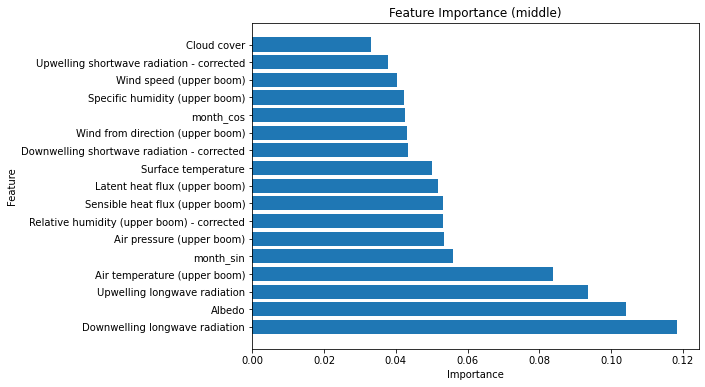

R^2 score on test set (end):  -53.20584635258047
MSE on test set (end):  0.016320363722215066
                                        Feature  Importance
0                 Latent heat flux (upper boom)    0.201765
1                  Upwelling longwave radiation    0.181675
2                                     month_cos    0.138465
3     Upwelling shortwave radiation - corrected    0.085721
4                     Air pressure (upper boom)    0.079949
5                Specific humidity (upper boom)    0.075987
6                  Air temperature (upper boom)    0.063185
7               Sensible heat flux (upper boom)    0.057158
8    Relative humidity (upper boom) - corrected    0.041070
9                                        Albedo    0.032176
10               Downwelling longwave radiation    0.015503
11                                  Cloud cover    0.008247
12  Downwelling shortwave radiation - corrected    0.006875
13             Wind from direction (upper boom)    0.004475
14    

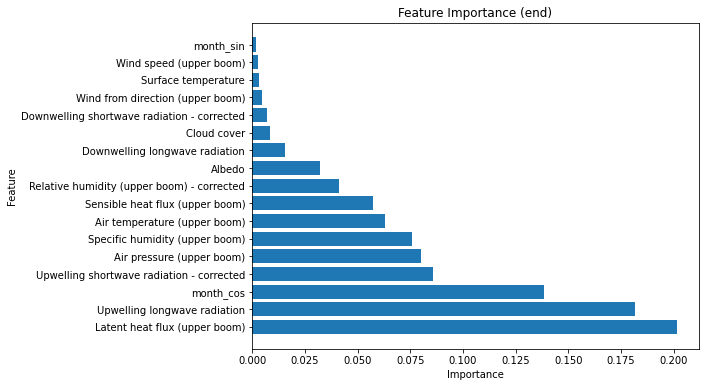

In [224]:
### This bit for delta
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_delta_train.index)
    y_Train_valid_indices = indices.intersection(y_delta_train.index)
    X_Test_valid_indices = indices.intersection(X_delta_test.index)
    y_Test_valid_indices = indices.intersection(y_delta_test.index)

    # filter out by indeces
    X_train_category = X_delta_train.loc[X_Train_valid_indices]
    y_train_category = y_delta_train.loc[y_Train_valid_indices]
    X_test_category = X_delta_test.loc[X_Test_valid_indices]
    y_test_category = y_delta_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    model_delta.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_delta.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_delta_train.columns, 'Importance': model_delta.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()


R^2 score on test set (pre):  0.37453496673121267
MSE on test set (pre):  162.62310907551793
                                        Feature  Importance
0   Downwelling shortwave radiation - corrected    0.106521
1                                     month_sin    0.102369
2    Relative humidity (upper boom) - corrected    0.098443
3                 Latent heat flux (upper boom)    0.071425
4              Wind from direction (upper boom)    0.060405
5                                   Cloud cover    0.056787
6                  Upwelling longwave radiation    0.054040
7                                     month_cos    0.052791
8     Upwelling shortwave radiation - corrected    0.052469
9                       Wind speed (upper boom)    0.050695
10                                       Albedo    0.049416
11              Sensible heat flux (upper boom)    0.044496
12               Specific humidity (upper boom)    0.043156
13                          Surface temperature    0.042605
14     

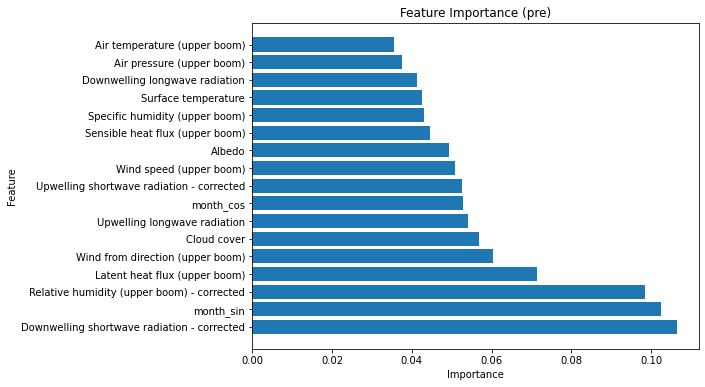

R^2 score on test set (beginning):  0.24721145406442746
MSE on test set (beginning):  197.60389336604678
                                        Feature  Importance
0                  Upwelling longwave radiation    0.100076
1                           Surface temperature    0.090652
2                 Latent heat flux (upper boom)    0.087091
3                       Wind speed (upper boom)    0.079399
4    Relative humidity (upper boom) - corrected    0.073440
5               Sensible heat flux (upper boom)    0.071699
6                Downwelling longwave radiation    0.071539
7                                        Albedo    0.062573
8              Wind from direction (upper boom)    0.060781
9                Specific humidity (upper boom)    0.060585
10                                  Cloud cover    0.059804
11    Upwelling shortwave radiation - corrected    0.058269
12  Downwelling shortwave radiation - corrected    0.050118
13                    Air pressure (upper boom)    0.03

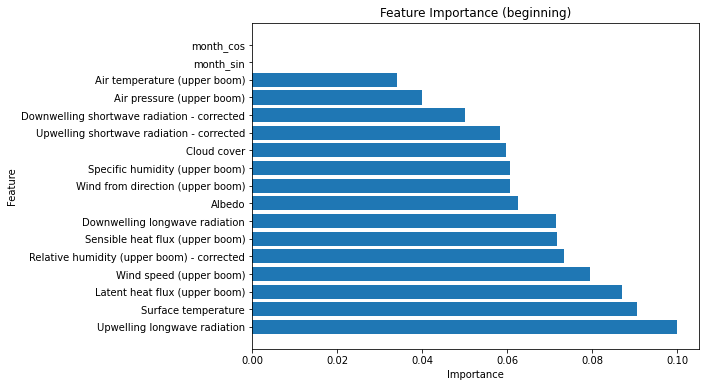

R^2 score on test set (middle):  0.35491737224356734
MSE on test set (middle):  158.61966909610842
                                        Feature  Importance
0    Relative humidity (upper boom) - corrected    0.104025
1                           Surface temperature    0.088304
2                Specific humidity (upper boom)    0.080281
3                 Latent heat flux (upper boom)    0.071035
4                       Wind speed (upper boom)    0.068356
5     Upwelling shortwave radiation - corrected    0.064479
6                                     month_sin    0.060501
7                  Upwelling longwave radiation    0.057538
8                                     month_cos    0.052553
9              Wind from direction (upper boom)    0.049453
10                    Air pressure (upper boom)    0.047561
11               Downwelling longwave radiation    0.046499
12              Sensible heat flux (upper boom)    0.045928
13                                       Albedo    0.044952
1

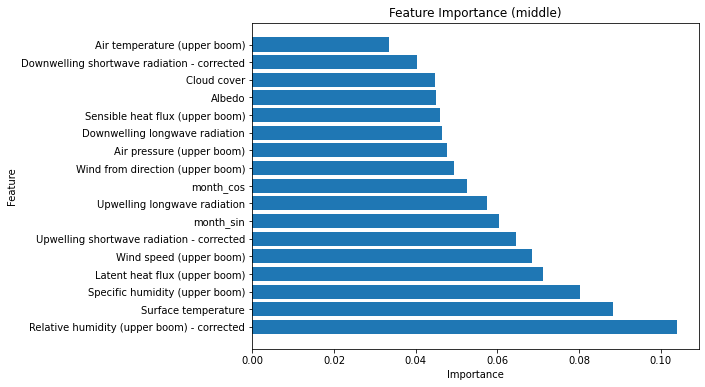

R^2 score on test set (end):  0.328399790789749
MSE on test set (end):  145.5136864609126
                                        Feature  Importance
0                 Latent heat flux (upper boom)    0.102608
1                                        Albedo    0.084982
2                Specific humidity (upper boom)    0.069892
3                                     month_cos    0.069235
4                     Air pressure (upper boom)    0.066184
5                  Upwelling longwave radiation    0.063553
6               Sensible heat flux (upper boom)    0.058568
7     Upwelling shortwave radiation - corrected    0.057894
8   Downwelling shortwave radiation - corrected    0.054490
9              Wind from direction (upper boom)    0.052260
10   Relative humidity (upper boom) - corrected    0.052117
11                                    month_sin    0.049878
12                                  Cloud cover    0.049843
13                      Wind speed (upper boom)    0.046067
14        

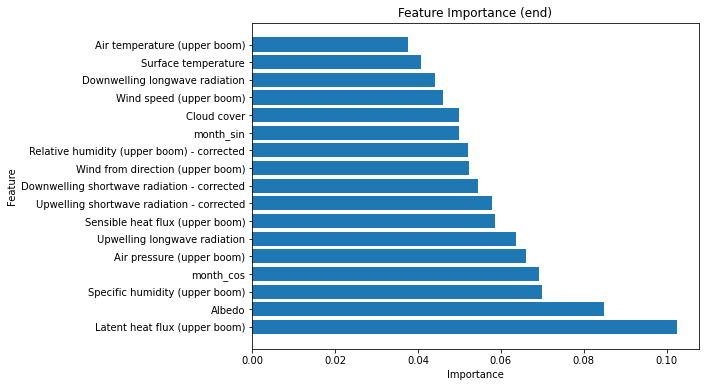

In [225]:
### This bit for absolute
for category in ['pre', 'beginning', 'middle', 'end']:
    indices = eval(f"indices_{category}")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(X_absolute_train.index)
    y_Train_valid_indices = indices.intersection(y_absolute_train.index)
    X_Test_valid_indices = indices.intersection(X_absolute_test.index)
    y_Test_valid_indices = indices.intersection(y_absolute_test.index)

    # filter out by indeces
    X_train_category = X_absolute_train.loc[X_Train_valid_indices]
    y_train_category = y_absolute_train.loc[y_Train_valid_indices]
    X_test_category = X_absolute_test.loc[X_Test_valid_indices]
    y_test_category = y_absolute_test.loc[y_Test_valid_indices]

    # Apply XGB on all periods  
    model_absolute.fit(X_train_category, y_train_category)  # Fit a new model on each subset
    y_pred_category = model_absolute.predict(X_test_category)

    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({category}): ", r2)
    print(f"MSE on test set ({category}): ", mse)

    # Get the feature importance scores and plot them
    feature_importance = pd.DataFrame({'Feature': X_absolute_train.columns, 'Importance': model_absolute.feature_importances_})
    feature_importance = feature_importance.sort_values('Importance', ascending=False).reset_index(drop=True)
    print(feature_importance)

    # Plot the feature importance scores
    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 6))
    plt.barh(feature_importance['Feature'], feature_importance['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title(f'Feature Importance ({category})')
    plt.show()


## Test Suite

In [231]:
# This bit to find best LSTM model for when Ablation == True and for both target variables

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

for i in ["delta","absolute"]:
    
    indices = eval(f"indices_ablation")  # Get the indices for the current category

    # Find common indexes
    X_Train_valid_indices = indices.intersection(eval(f"X_{i}_train").index)
    y_Train_valid_indices = indices.intersection(eval(f"y_{i}_train").index)
    X_Test_valid_indices = indices.intersection(eval(f"X_{i}_test").index)
    y_Test_valid_indices = indices.intersection(eval(f"y_{i}_test").index)

    # filter out by indeces
    X_train_category = eval(f"X_{i}_train").loc[X_Train_valid_indices]  
    y_train_category = eval(f"y_{i}_train").loc[y_Train_valid_indices] 
    X_test_category = eval(f"X_{i}_test").loc[X_Test_valid_indices]  
    y_test_category = eval(f"y_{i}_test").loc[y_Test_valid_indices]
    
    # Impute missing values
    X_train_category = X_train_category.fillna(X_train_category.mean())
    y_train_category = y_train_category.fillna(y_train_category.mean())
    X_test_category = X_test_category.fillna(X_test_category.mean())

    
    # Reshape the input data to 3D array
    X_train_category = X_train_category.values.reshape((X_train_category.shape[0], 1, X_train_category.shape[1]))
    X_test_category = X_test_category.values.reshape((X_test_category.shape[0], 1, X_test_category.shape[1]))
    
    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(1, X_train_category.shape[2])))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(loss='mse', optimizer='adam')
    
    # Fit the model to the training data
    model.fit(X_train_category, y_train_category, epochs=50, batch_size=64, validation_data=(X_test_category, y_test_category), verbose=0)
    
    # Evaluate the model on the test set
    y_pred_category = model.predict(X_test_category)
    r2 = r2_score(y_test_category, y_pred_category)
    mse = mean_squared_error(y_test_category, y_pred_category)
    print(f"R^2 score on test set ({i}): ", r2)
    print(f"MSE on test set ({i}): ", mse)


R^2 score on test set (delta):  0.01694059659070657
MSE on test set (delta):  0.036556207210339295
R^2 score on test set (absolute):  0.007700725191564284
MSE on test set (absolute):  245.25185932755036


--------